# DIVAnd full analysis

This notebook presents the different steps necessary for the creation of a climatology:
1. ODV data reading.
2. Extraction of bathymetry and creation of mask
3. Data download from other sources and duplicate removal.
4. Quality control.
5. Parameter optimisation.
6. Spatio-temporal interpolation with `DIVAnd`.

In [1]:
using Pkg
Pkg.status()

Status `/opt/julia/environments/v1.9/Project.toml`
  [336ed68f] CSV v0.10.11
  [efc8151c] DIVAnd v2.7.9
  [cf87cc76] DataAssim v0.4.0
  [864edb3b] DataStructures v0.18.15
  [7a1cc6ca] FFTW v1.7.1
  [5789e2e9] FileIO v1.16.1
  [c27321d9] Glob v1.3.1
  [f67ccb44] HDF5 v0.16.15
  [cd3eb016] HTTP v1.9.14
  [7073ff75] IJulia v1.24.2
  [82e4d734] ImageIO v0.6.7
  [916415d5] Images v0.26.0
  [c601a237] Interact v0.10.5
  [a98d9a8b] Interpolations v0.14.7
  [682c06a0] JSON v0.21.4
  [1902f260] Knet v1.4.10
  [23992714] MAT v0.10.5
  [e1d29d7a] Missings v1.1.0
  [85f8d34a] NCDatasets v0.12.17
  [9b87118b] PackageCompiler v2.1.7
  [3725be50] PhysOcean v0.6.7
  [c3e4b0f8] Pluto v0.19.27
  [438e738f] PyCall v1.96.1
  [d330b81b] PyPlot v2.11.1
  [f2b01f46] Roots v2.0.17
  [276daf66] SpecialFunctions v2.3.0
  [860ef19b] StableRNGs v1.0.0
  [d6d074c3] VideoIO v1.0.7


### Import packages

In [2]:
using NCDatasets
using PhysOcean
using DataStructures
using DIVAnd
using Dates
using Statistics
using Random
using Printf
using PyPlot

[ Info: Precompiling NCDatasets [85f8d34a-cbdd-5861-8df4-14fed0d494ab]
[ Info: Precompiling PhysOcean [3725be50-bbbd-5592-92c3-2f0e82159c3e]
[ Info: Precompiling DIVAnd [efc8151c-67de-5a8f-9a35-d8f54746ae9d]
[ Info: Precompiling PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
[ Info: Precompiling RatiosFixedPointNumbersExt [dc815b64-233b-5bd3-8c5c-a58ec2b485bf]


## Configuration
* Define the horizontal, vertical (depth levels) and temporal resolutions.
* Select the variable of interest

In [4]:
dx, dy = 0.125, 0.125
lonr = 19:dx:30
latr = 32:dy:38
timerange = [Date(1950,1,1),Date(2017,12,31)];

depthr = [0.,5., 10., 15., 20., 25., 30., 40., 50., 66, 
    75, 85, 100, 112, 125, 135, 150, 175, 200, 225, 250, 
    275, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 
    800, 850, 900, 950, 1000, 1050, 1100, 1150, 1200, 1250, 
    1300, 1350, 1400, 1450, 1500, 1600, 1750, 1850, 2000];
depthr = [0.,10.,20.];

In [43]:
varname = "Nitrate"
yearlist = [1900:2020];
monthlist = [[1,2,3],[4,5,6],[7,8,9],[10,11,12]];

We create here the variable TS (for "_time selector_"), which allows us to work with the observations corresponding to each period of interest.

In [6]:
TS = DIVAnd.TimeSelectorYearListMonthList(yearlist,monthlist);
@show TS;

TS = TimeSelectorYearListMonthList{Vector{UnitRange{Int64}}, Vector{Vector{Int64}}}(UnitRange{Int64}[1900:2020], [[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12]])


## 1. Read your ODV file
Adapt the `datadir` and `datafile` values.     
The example is based on a sub-setting of the [Mediterranean Sea](https://www.seadatanet.org/Products#/metadata/cd552057-b604-4004-b838-a4f73cc98fcf) aggregated dataset.      
The dataset has been extracted around the Adriatic Sea and exported to a netCDF using [Ocean Data View](https://odv.awi.de/).
<img src="./Images/MedSeaAggreg.jpg" width="450px">

In [9]:
datadir = "../data"
smalldatafile = joinpath(datadir, "1_data_from_Eutrophication_Med_profiles_2022_unrestricted.netcdf")
datafile = joinpath(datadir, "1_data_from_Eutrophication_Med_profiles_2022_unrestricted.netcdf")
isdir(datadir) ? @info("Directory already created") : mkpath(datadir)

[ Info: Directory already created


In [10]:
@time obsval,obslon,obslat,obsdepth,obstime,obsid = NCODV.load(Float64, smalldatafile, 
    "Water body nitrate");

6690 out of 7990 - 83.729662077597 %
  7.021592 seconds (5.01 M allocations: 534.325 MiB, 3.19% gc time, 47.02% compilation time)


Then you can read the full file:

In [11]:
@time obsval,obslon,obslat,obsdepth,obstime,obsid = NCODV.load(Float64, datafile, 
    "Water body nitrate");

6000 out of 7990 - 75.09386733416771 %
  4.748925 seconds (3.17 M allocations: 411.449 MiB, 3.72% gc time)


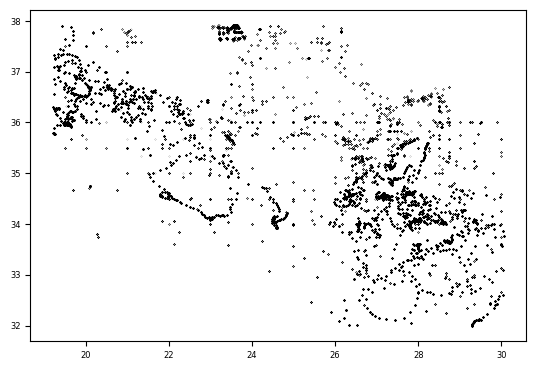

In [12]:
figure("Mediterranean-Data")
ax = subplot(1,1,1)
plot(obslon, obslat, "ko", markersize=.1, markerfacecolor="k")
aspectratio = 1/cos(mean(latr) * pi/180)
ax.tick_params("both",labelsize=6)
gca().set_aspect(aspectratio)

Check the extremal values of the observations

In [13]:
checkobs((obslon,obslat,obsdepth,obstime),obsval,obsid)

[ Info: Checking ranges for dimensions and observations


              minimum and maximum of obs. dimension 1: (19.210620880126953, 30.05562973022461)
              minimum and maximum of obs. dimension 2: (31.986299514770508, 37.92333221435547)
              minimum and maximum of obs. dimension 3: (0.0, 4512.64892578125)
              minimum and maximum of obs. dimension 4: (DateTime("1930-05-14T23:00:00"), DateTime("2019-07-08T10:27:00"))
                          minimum and maximum of data: (0.00030750001315027475, 42.220001220703125)


## 2. Extract the bathymetry
It is used to delimit the domain where the interpolation is performed.

### 2.1 Choice of bathymetry
Modify `bathname` according to the resolution required.

In [32]:
bathname = "../data/gebco_30sec_8.nc"
isfile(bathname) ? @info("Bathymetry file already downloaded") : download("https://dox.ulg.ac.be/index.php/s/U0pqyXhcQrXjEUX/download", bathname)

"../data/gebco_30sec_8.nc"

In [33]:
@time bx,by,b = load_bath(bathname,true,lonr,latr);

  2.709484 seconds (2.30 M allocations: 148.437 MiB, 11.27% gc time, 98.08% compilation time)


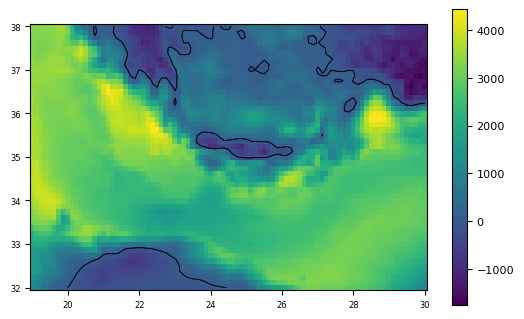

In [34]:
figure("Mediterranean-Bathymetry")
ax = subplot(1,1,1)
pcolor(bx, by, permutedims(b, [2,1]));
colorbar(orientation="vertical", shrink=0.8).ax.tick_params(labelsize=8)
contour(bx, by, permutedims(b, [2,1]), [0, 0.1], colors="k", linewidths=.5)
gca().set_aspect(aspectratio)
ax.tick_params("both",labelsize=6)

### 2.2 Create mask
* False for sea        
* True for land

In [35]:
mask = falses(size(b,1),size(b,2),length(depthr))
for k = 1:length(depthr)
    for j = 1:size(b,2)
        for i = 1:size(b,1)
            mask[i,j,k] = b[i,j] >= depthr[k]
        end
    end
end
@show size(mask)

size(mask) = (89, 49, 3)


(89, 49, 3)

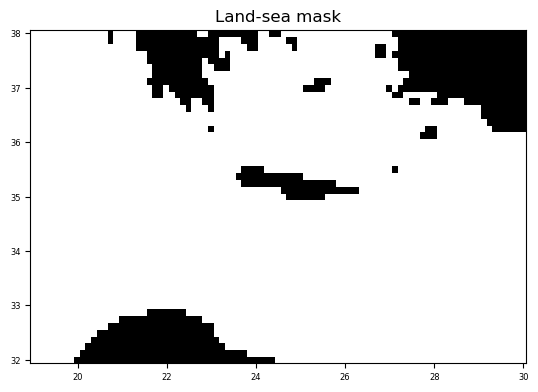

PyObject Text(0.5, 1.0, 'Land-sea mask')

In [36]:
figure("Mediterranean-Mask")
ax = subplot(1,1,1)
gca().set_aspect(aspectratio)
ax.tick_params("both",labelsize=6)
ax.pcolor(bx, by, transpose(mask[:,:,1]), cmap=PyPlot.cm.binary_r)
ax.set_title("Land-sea mask")

## 4. Quality control
We check the salinity value.     
Adapt the criteria to your region and variable.

In [37]:
sel = (obsval .<= 40) .& (obsval .>= 25);

In [38]:
obsval = obsval[sel]
obslon = obslon[sel]
obslat = obslat[sel]
obsdepth = obsdepth[sel]
obstime = obstime[sel]
obsid = obsid[sel];

## 5. Analysis parameters

### Modify data weight 
⌛⌛⌛       
Compute the new weights that takes into account close points.     
If the dataset is large, this can take a few minutes.     
The maximal and mean values provide an indication of the spatial proximity between the data.    
If you apply this technique, you need to adapt `epsilon2`:

In [39]:
#@time rdiag=1.0./DIVAnd.weight_RtimesOne((obslon,obslat),(0.03,0.03));
#@show maximum(rdiag),mean(rdiag)

### Correlation lengths and noise-to-signal ratio
We will use the function `diva3D` for the calculations.     
With this function, the correlation length has to be defined in meters, not in degrees.

In [41]:
sz = (length(lonr),length(latr),length(depthr));
lenx = fill(100_000.,sz)   # 100 km
leny = fill(100_000.,sz)   # 100 km
lenz = fill(25.,sz);      # 25 m 
len = (lenx, leny, lenz);
epsilon2 = 0.1;
#epsilon2 = epsilon2 * rdiag;

### Output file name

In [52]:
outputdir = "../outputs/"
if !isdir(outputdir)
    mkpath(outputdir)
end
filename = joinpath(outputdir, "Water_body_$(replace(varname," "=>"_"))_Mediterranean.nc")

"../outputs/Water_body_Nitrate_Mediterranean.nc"

## 7. Analysis

Remove the result file before running the analysis, otherwise you'll get the message     
```julia
NCDatasets.NetCDFError(13, "Permission denied")
```

In [53]:
if isfile(filename)
    rm(filename) # delete the previous analysis
    @info "Removing file $filename"
end

### 7.1 Plotting function
Define a plotting function that will be applied for each time index and depth level.     
All the figures will be saved in a selected directory.

In [54]:
figdir = "../outputs/"
if ~(isdir(figdir))
    mkdir(figdir)
else
    @info("Figure directory already exists")
end

[ Info: Figure directory already exists


In [55]:
function plotres(timeindex,sel,fit,erri)
    tmp = copy(fit)
    nx,ny,nz = size(tmp)
    for i in 1:nz
        figure("Mediterranean-Additional-Data")
        ax = subplot(1,1,1)
        ax.tick_params("both",labelsize=6)
        ylim(39.0, 46.0);
        xlim(11.5, 20.0);
        title("Depth: $(depthr[i]) \n Time index: $(timeindex)", fontsize=6)
        pcolor(lonr.-dx/2.,latr.-dy/2, permutedims(tmp[:,:,i], [2,1]);
               vmin = 33, vmax = 40)
        colorbar(extend="both", orientation="vertical", shrink=0.8).ax.tick_params(labelsize=8)

        contourf(bx,by,permutedims(b,[2,1]), levels = [-1e5,0],colors = [[.5,.5,.5]])
        aspectratio = 1/cos(mean(latr) * pi/180)
        gca().set_aspect(aspectratio)
        
        figname = varname * @sprintf("_%02d",i) * @sprintf("_%03d.png",timeindex)
        PyPlot.savefig(joinpath(figdir, figname), dpi=600, bbox_inches="tight");
        PyPlot.close_figs()
    end
end

plotres (generic function with 1 method)

### 7.2 Create the gridded fields using `diva3d`
Here only the noise-to-signal ratio is estimated.     
Set `fitcorrlen` to `true` to also optimise the correlation length.

In [ ]:
@time dbinfo = diva3d((lonr,latr,depthr,TS),
    (obslon,obslat,obsdepth,obstime), obsval,
    len, epsilon2,
    filename,varname,
    bathname=bathname,
    plotres = plotres,
    fitcorrlen = false,
    niter_e = 2,
    surfextend = true
    );

[ Info: Creating netCDF file ../outputs/Water_body_Nitrate_Mediterranean.nc
[ Info: Time step 1 / 4
┌ Warning: no data at 1
└ @ DIVAnd /opt/julia/packages/DIVAnd/MV3j9/src/diva.jl:432
[ Info: Time step 2 / 4
[ Info: scaled correlation length (min,max) in dimension 1: (100000.0, 100000.0)
[ Info: scaled correlation length (min,max) in dimension 2: (100000.0, 100000.0)
[ Info: scaled correlation length (min,max) in dimension 3: (25.0, 25.0)
[ Info: number of windows: 1


Save the observation metadata in the NetCDF file.      

In [51]:
DIVAnd.saveobs(filename,(obslon,obslat,obsdepth,obstime),obsid);